In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
import time

/home/luke/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using backend: pytorch



In [2]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

In [37]:
def solvePDEAdaptive(I, a, L, dt,F, T, lam, solveControl, kernelEstimator, gamma, lamGuess):
    # Code adapted from: https://hplgit.github.io/fdm-book/doc/pub/book/pdf/fdm-book-4print.pdf
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    lArr = []
    kArr = []
    lHat = lamGuess
    lArr.append(lHat)

    u = np.zeros((Nt, Nx+1))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u[0][i] = I[i]

    for i in range(1, Nt):
        kEst = kernelEstimator(lHat, dx)
        if i % int(Nt/100) == 0:
            print("i", i, "/", nt)
            print("wTerm", wTerm)
            print("uTerm", uTerm)
            print("lhatdelta", lHatDelta)
            kArr.append(kEst)
            
        # Compute u at inner mesh points
        u[i][1:Nx] = u[i-1][1:Nx] +  \
                      F*(u[i-1][0:Nx-1] - 2*u[i-1][1:Nx] + u[i-1][2:Nx+1]) + dt*lam[1:Nx]*u[i-1][1:Nx]

        lHatDelta,wTerm, uTerm = estimateLambdaHatDelta(x, u[i-1], kEst, dx, gamma)
        lHat = lHat + dt*lHatDelta
        # Insert boundary conditions
        u[i][0] = 0;  u[i][Nx] = solveControl(u[i], kEst, Nx-1, dx)
        lArr.append(lHat)
    return u, x, lArr, kArr

def solvePDE(I, a, L, dt,F, T, lam, solveControl, kernel):
    # Code adapted from: https://hplgit.github.io/fdm-book/doc/pub/book/pdf/fdm-book-4print.pdf
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    u = np.zeros((Nt, Nx+1))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u[0][i] = I[i]

    for i in range(1, Nt):
        if i % int(Nt/10) == 0:
            print("i", i, "/", nt)
        # Compute u at inner mesh points
        u[i][1:Nx] = u[i-1][1:Nx] +  \
                      F*(u[i-1][0:Nx-1] - 2*u[i-1][1:Nx] + u[i-1][2:Nx+1]) + dt*lam[1:Nx]*u[i-1][1:Nx]

        # Insert boundary conditions
        u[i][0] = 0;  u[i][Nx] = solveControl(u[i], kernel, Nx-1, dx)
    return u, x

def solveKernelFunction(lam, dx):
    k = np.zeros((len(lam), len(lam)))
    # First we calculate a at each timestep
    a = lam

    # FD LOOP
    k[1][1] = -(a[1] + a[0]) * dx / 4
    for i in range(1, len(lam)-1):
        k[i+1][0] = 0
        k[i+1][i+1] = k[i][i]-dx/4.0*(a[i-1] + a[i])
        k[i+1][i] = k[i][i] - dx/2 * a[i]
        for j in range(1, i):
                k[i+1][j] = -k[i-1][j] + k[i][j+1] + k[i][j-1] + a[j]*(dx**2)*(k[i][j+1]+k[i][j-1])/2
    return k

def solveLambdaFunction(x, gamma):
    lam = np.zeros(nx)
    for idx, val in enumerate(x):
        lam[idx] = 5
    return lam

def solveControl(u, kernel, nx, dx):
    return sum(kernel[-1][0:nx+1]*u[0:nx+1])*dx


def openLoop(u, kernel, nx, dx):
    return 0

def zeroToNan(x):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if j >= i:
                x[i][j] = float('nan')
    return x

# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt-1)
    for i in range(1, nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i-1] = error
    return pdeError

def solveW(u, kernel, dx):
    w = np.zeros(len(kernel))
    for i in range(0, len(k)):
        w[i] = u[i]-sum(k[i][0:i]*u[0:i])*dx
    return w

def solveWIntegral(x, w, dx):
    return sum(w[0:]**2)*dx

def estimateLambdaHatDelta(x, u, k, dx, gamma):
    w = solveW(u, k, dx)
    wInt = solveWIntegral(x, w, dx)
    lambdaHat = np.zeros(len(w))
    kt= k.transpose()
    for i in range(0, len(w)):
        middleTerm = (w[i] - sum(kt[i][i:]*w[i:])*dx)*u[i]
        lambdaHat[i] = gamma/(1+wInt)*middleTerm 
    return lambdaHat, wInt, middleTerm

In [54]:
X = 1
dx = 0.005
nx = int(round(X/dx))
spatial = np.linspace(0, X, nx+1, dtype=np.float32)


T = 1
dt = 0.00001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt, dtype=np.float32)

In [55]:
init_cond = np.zeros(nx+1)
lam = np.zeros(nx+1)
lamGuess = np.zeros(nx+1)
for j in range(nx+1):
    init_cond[j] = 10
    lam[j] = 50*math.cos(7*math.acos(spatial[j]))
    lamGuess[j] = 1
    
u, s2, lArr, kArr= solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControl, solveKernelFunction, 50, lamGuess)

i 1000 / 100000
wTerm 653.5268013831603
uTerm -142.807672204002
lhatdelta [ 0.00000000e+00  3.96935492e-03  1.58459160e-02  3.55373247e-02
  6.28943961e-02  9.77155350e-02  1.39751779e-01  1.88711795e-01
  2.44267646e-01  3.06059917e-01  3.73703930e-01  4.46794583e-01
  5.24912765e-01  6.07629544e-01  6.94512584e-01  7.85129382e-01
  8.79053556e-01  9.75866891e-01  1.07516543e+00  1.17656017e+00
  1.27968294e+00  1.38418564e+00  1.48974599e+00  1.59606524e+00
  1.70287386e+00  1.80992779e+00  1.91701412e+00  2.02394599e+00
  2.13056841e+00  2.23675174e+00  2.34239799e+00  2.44743289e+00
  2.55181273e+00  2.65551522e+00  2.75854704e+00  2.86093342e+00
  2.96272667e+00  3.06399450e+00  3.16482961e+00  3.26533687e+00
  3.36564408e+00  3.46588791e+00  3.56622612e+00  3.66682207e+00
  3.76785862e+00  3.86952113e+00  3.97201313e+00  4.07553777e+00
  4.18031532e+00  4.28656298e+00  4.39451442e+00  4.50439759e+00
  4.61645667e+00  4.73092761e+00  4.84806261e+00  4.96810319e+00
  5.09130749e+00

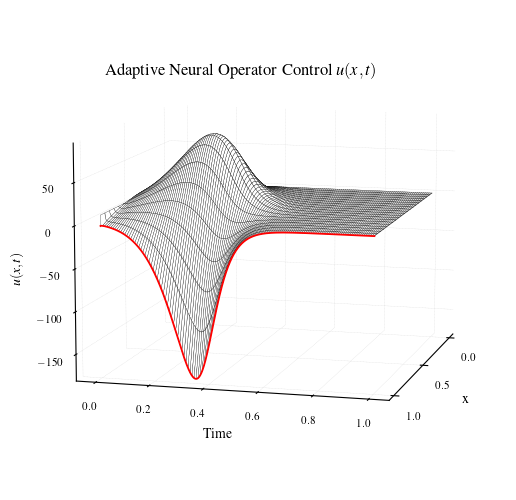

In [56]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1,1), height_add=0))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(r"Adaptive Neural Operator Control $u(x, t)$")
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, u, edgecolor="black",lw=0.2, rstride=750, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (u.transpose())[-1] 
axes.plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time")
axes.set_zlabel(r"$u(x, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("adaptiveControlParabolicBig.pdf", dpi=300)

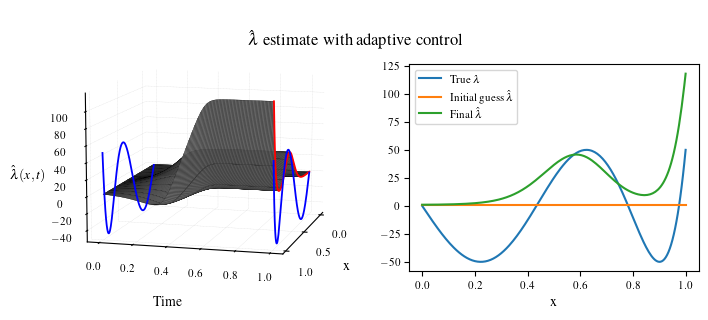

In [60]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1, 2), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=2, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.15, bottom=0, right=1, top=1.1)
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
lArr=  np.array(lArr)

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, lArr, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time", labelpad=10)
axes.set_zlabel(r"$\hat{\lambda}(x, t)$")
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
vals = lArr[-1]
test = np.ones(len(lam))*temporal[-1]

axes.plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
axes.plot(spatial, test, lam, color="blue", lw=1.3, antialiased=True)
axes.plot(spatial, np.zeros(len(lam)), lam, color="blue", lw=1.3, antialiased=True)


subfig = subfigs[1]
# subfig.suptitle(r"Comparison of initial and final $\hat{\beta}$ for $\sigma=2.9, 3.1$")

subfig.subplots_adjust(left=0.15, bottom=0.2, right=0.97, top=0.85, wspace=0.3, hspace=0.1)
axes = subfig.subplots(nrows=1, ncols=1)
axes.plot(spatial, lam, label=r"True $\lambda$")
axes.plot(spatial, np.ones(len(lam)), label=r"Initial guess $\hat{\lambda}$")
axes.plot(spatial, lArr[-1], label=r"Final  $\hat{\lambda}$")
axes.legend()
axes.set_xlabel("x")

subfig.suptitle(r"$\hat{\lambda}$ estimate with adaptive control", x=0, y=0.96, ha="center")
plt.savefig("lambdaComparisonTight.pdf", dpi=300)

In [ ]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (2, 3), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=2, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.15, bottom=0, right=1, top=1.1)
axes = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})
lArr=  np.array(lArr)

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, lArr, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time", labelpad=10)
axes.set_zlabel(r"$\hat{\lambda}(x, t)$")
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
vals = lArr[-1]
test = np.ones(len(lam))*temporal[-1]

axes.plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
axes.plot(spatial, test, lam, color="blue", lw=1.3, antialiased=True)
axes.plot(spatial, np.zeros(len(lam)), lam, color="blue", lw=1.3, antialiased=True)


subfig = subfigs[1]
# subfig.suptitle(r"Comparison of initial and final $\hat{\beta}$ for $\sigma=2.9, 3.1$")

subfig.subplots_adjust(left=0.15, bottom=0.2, right=0.97, top=0.85, wspace=0.3, hspace=0.1)
axes = subfig.subplots(nrows=1, ncols=1)
axes.plot(spatial, lam, label=r"True $\lambda$")
axes.plot(spatial, np.ones(len(lam)), label=r"Initial guess $\hat{\lambda}$")
axes.plot(spatial, lArr[-1], label=r"Final  $\hat{\lambda}$")
axes.legend()
axes.set_xlabel("x")

subfig.suptitle(r"$\hat{\lambda}$ estimate with adaptive control", x=0, y=0.96, ha="center")
plt.savefig("lambdaComparisonTight.pdf", dpi=300)

In [42]:
def solveW(u, kernel, dx):
    w = np.zeros(len(kernel))
    for i in range(0, len(k)):
        w[i] = u[i]-sum(k[i][0:i]*u[0:i])*dx
    return w

def solveWIntegral(x, w, dx):
    return sum(w[0:]**2)*dx

def estimateLambdaHatDelta(x, u, k, dx, gamma):
    w = solveW(u, k, dx)
    wInt = solveWIntegral(x, w, dx)
    lambdaHat = np.zeros(len(w))
    kt= k.transpose()
    for i in range(0, len(w)):
        middleTerm = (w[i] - sum(kt[i][i:]*w[i:])*dx)*u[i]
        lambdaHat[i] = gamma/(1+wInt)*middleTerm 
    return lambdaHat, wInt, middleTerm

(201, 201)


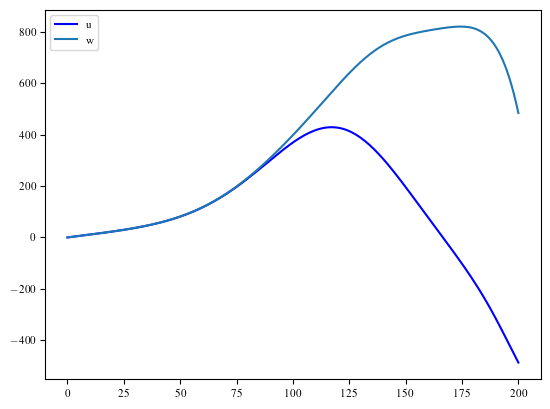

In [43]:
print(kArr[-1].shape)
estimate, wInt, middleTerm = estimateLambdaHatDelta(spatial, u[-100], kArr[-1], 0.005, 25)
kt = kArr[-1].transpose()
uVal = u[-100]
kVal = kArr[-1]
wVal = solveW(uVal, kVal, dx)
plt.plot(uVal, label="u", color="blue")
plt.plot(wVal, label="w")
plt.legend()

In [8]:
init_cond = np.zeros(nx+1)
lam = np.zeros(nx+1)
lamGuess = np.zeros(nx+1)
for j in range(nx+1):
    init_cond[j] = 1
    lam[j] = 50*math.cos(6*math.acos(spatial[j]))
    lamGuess[j] = 1
k = solveKernelFunction(lam, dx)
    
uopen, s2= solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, lam, openLoop, k)
print(uopen[-1])

i 15000 / 150000
i 30000 / 150000
i 45000 / 150000
i 60000 / 150000
i 75000 / 150000
i 90000 / 150000
i 105000 / 150000
i 120000 / 150000
i 135000 / 150000
[0.00000000e+00 4.62961487e+09 9.26711032e+09 1.39203647e+10
 1.85972519e+10 2.33056388e+10 2.80533827e+10 3.28483285e+10
 3.76983050e+10 4.26111219e+10 4.75945648e+10 5.26563911e+10
 5.78043242e+10 6.30460475e+10 6.83891980e+10 7.38413581e+10
 7.94100472e+10 8.51027129e+10 9.09267198e+10 9.68893388e+10
 1.02997734e+11 1.09258951e+11 1.15679898e+11 1.22267336e+11
 1.29027857e+11 1.35967868e+11 1.43093571e+11 1.50410942e+11
 1.57925712e+11 1.65643341e+11 1.73568994e+11 1.81707519e+11
 1.90063418e+11 1.98640820e+11 2.07443456e+11 2.16474626e+11
 2.25737170e+11 2.35233441e+11 2.44965271e+11 2.54933940e+11
 2.65140147e+11 2.75583974e+11 2.86264860e+11 2.97181563e+11
 3.08332136e+11 3.19713892e+11 3.31323376e+11 3.43156338e+11
 3.55207703e+11 3.67471548e+11 3.79941080e+11 3.92608608e+11
 4.05465530e+11 4.18502315e+11 4.31708485e+11 4.450

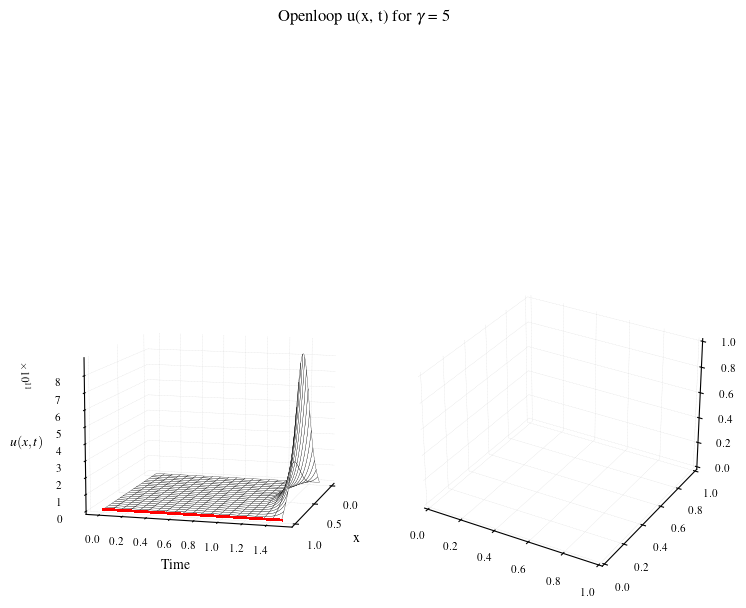

In [9]:
res = 10
fig = plt.figure(figsize=set_size(516, 0.99, (2, 1), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

#### OPEN LOOP PLOT ####
subfig = subfigs
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

subfig.suptitle(r"Openloop u(x, t) for $\gamma$ = 5")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, uopen, edgecolor="black",lw=0.2, rstride=res*750, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(int(nt))
vals = (uopen.transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$u(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)


plt.savefig("test.pdf", dpi=300)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (150000, 201) and arg 2 with shape (99, 201).

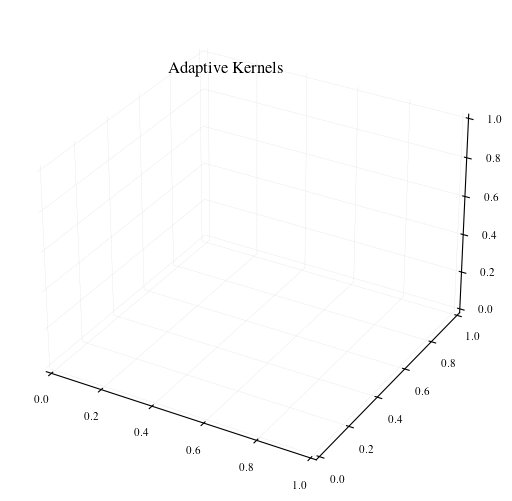

In [10]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1,1), height_add=0))
kArr = np.array(kArr)

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(r"Adaptive Kernels")
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, kArr.transpose()[0].transpose(), edgecolor="black",lw=0.2, rstride=750, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (u.transpose())[-1] 
axes.plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time")
axes.set_zlabel(r"$k(x, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("kernels.pdf", dpi=300)